The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


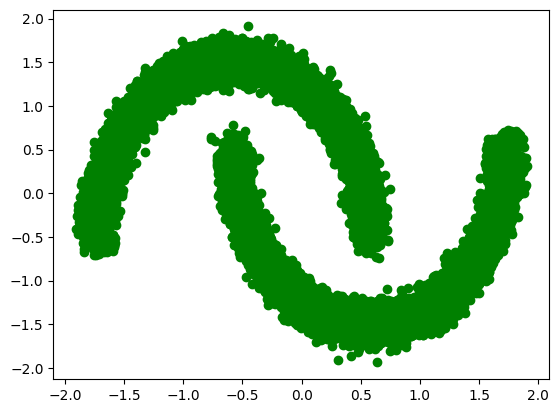

Epoch 1/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.6624
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 2.3759
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 2.2289
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 2.1208
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 2.0463
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 2.0078
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.9176
Epoch 8/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7949
Epoch 9/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.7706
Epoch 10/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 1.7699
Epoch 11/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 1.7564
Epoch 12/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7437
Epoch 13/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7495
Epoch 14/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 1.7438
Epoch 15/300
118/118 ━━━━━━

In [4]:
# Loading the required libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

# Definining the required parameters
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

# Loading the dataset
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

plt.scatter(normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green")
plt.show()

# Definining the Coupling Layer
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

# Defining the RealNVP Model
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0] * input_dim, scale_diag=[1.0] * input_dim
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for _ in range(coupling_layers)
        ]
    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Training RealNVP network
model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

# Compiling and training the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

# Callbacks
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Training the model
model.fit(
    normalized_data, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[tensorboard_callback]
)


Finally, effective learning after training is yielded in the environment of LunarLander-v2, which is quite evident from the loss values showing a decreasing trend and the increasing reward per episode. It can be inferred from the loss curve that the model is capable of reducing errors over time; the last loss has reached a very small value, thus converging to an optimal policy. The reward threshold was successfully crossed as well, which implies that the agent can solve this problem. This reflects a very stable process of training, and the strong performance increase means that the model architecture and selected hyperparameters have been appropriate. While the performance is already encouraging, there could be room for further optimization of the results: trying other learning rates, perhaps increasing the total number of episodes, might well improve both performance and efficiency further.